# Notebook to compare automatically detected snowline elevations to USGS ELA estimates

In [1]:
# ----Import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import glob
from scipy.stats import iqr

In [2]:
# -----Define paths in directory
# path to USGS mass balance data
usgs_path = '/Users/raineyaberle/Google Drive/My Drive/Research/PhD/GIS_data/USGS/benchmarkGlacier_massBalance/'
# path to study-sites/
study_sites_path = '/Users/raineyaberle/Google Drive/My Drive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/'
# path to snow-cover-mapping/
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/'

Wolverine
Gulkana
LemonCreek
SouthCascade


/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_2897/1963934150.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  usgs['Ba_Date'] = usgs['Ba_Date'].astype('datetime64[ns]')


Sperry


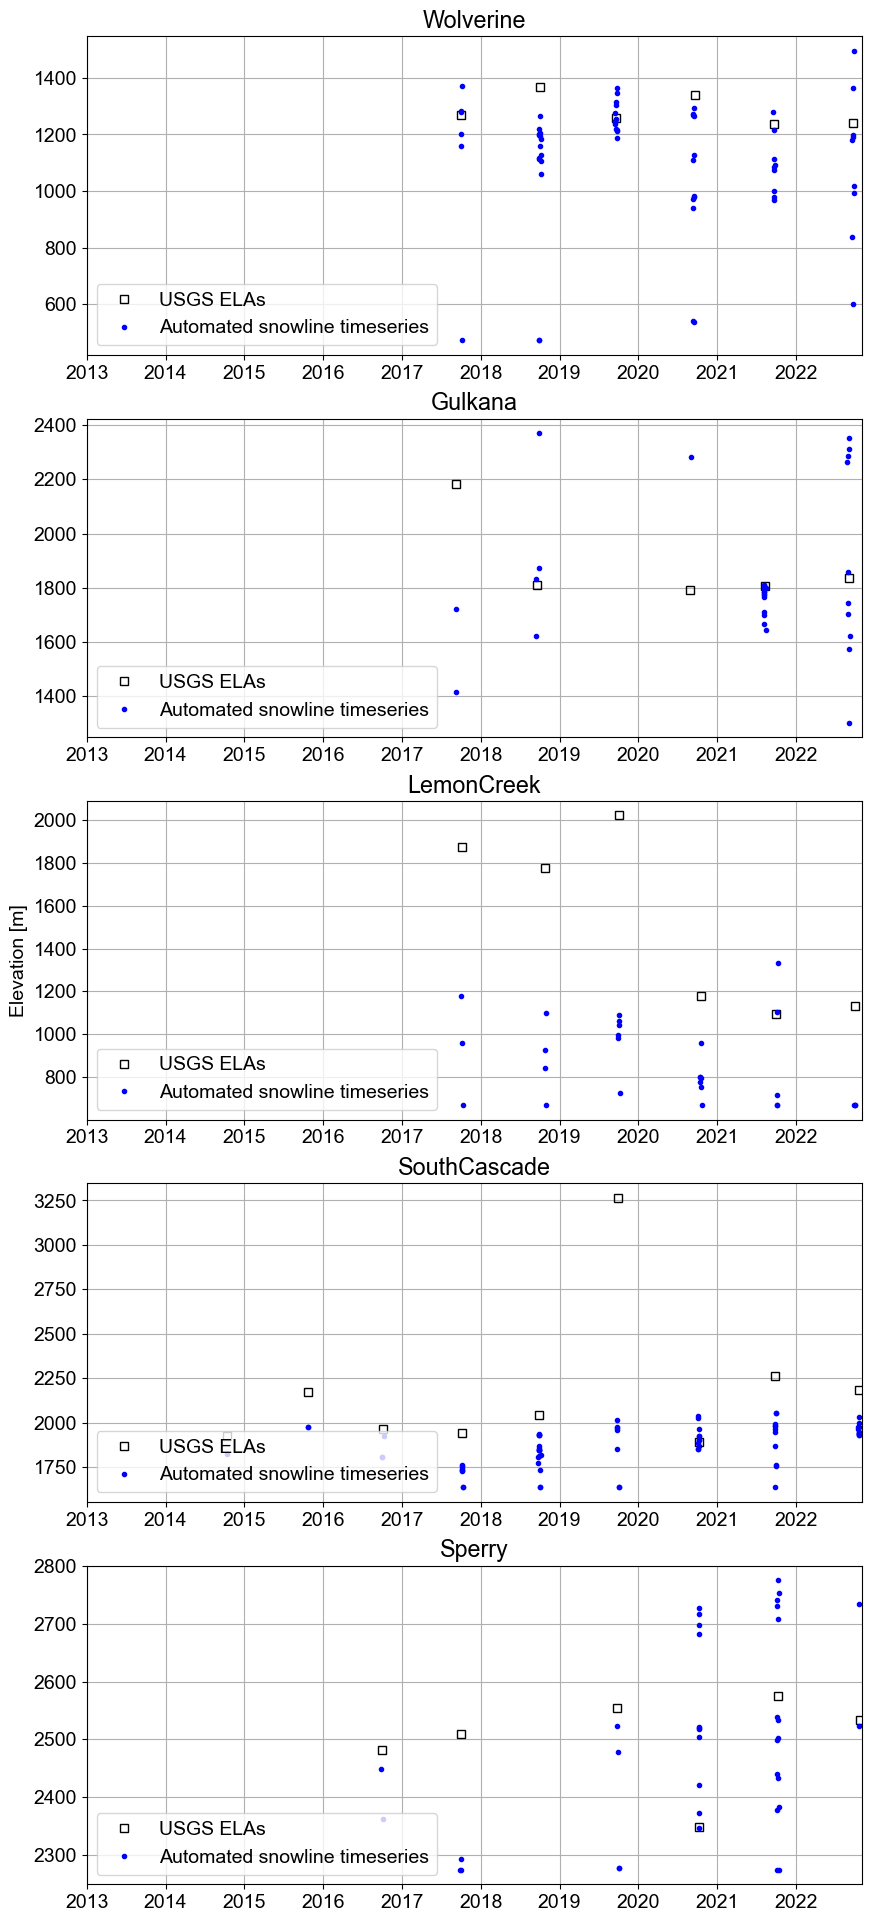

figure saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/figures/USGS_ELA_comparison.png
results stats saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/inputs-outputs/USGS_ELA_comparison_stats.csv


In [4]:
site_names = ['Wolverine', 'Gulkana', 'LemonCreek', 'SouthCascade', 'Sperry']

# set up figure
fig, ax = plt.subplots(len(site_names), 1, figsize=(10,24))
plt.rcParams.update({'font.size':14, 'font.sans-serif':'Arial'})

# initialize stats dataframe
results = pd.DataFrame()

# loop through sites
for i, site_name in enumerate(site_names):
    
    print(site_name)
    
    # load estimated snow lines  
    sl_est_fns = glob.glob(study_sites_path + site_name + '/imagery/snowlines/*snowline.csv')
    sl_ests = gpd.GeoDataFrame()
    for sl_est_fn in sl_est_fns:
        sl_est = pd.read_csv(sl_est_fn)
        sl_ests = pd.concat([sl_ests, sl_est])
    sl_ests.reset_index(drop=True, inplace=True)
    sl_ests['datetime'] = sl_ests['datetime'].astype('datetime64[ns]')
    
    # load USGS data
    usgs_fn = usgs_path + site_name + '/Output_' + site_name + '_Glacier_Wide_solutions_calibrated.csv'
    usgs = pd.read_csv(usgs_fn)
    usgs['Ba_Date'] = usgs['Ba_Date'].astype('datetime64[ns]')
    
    # grab unique years in snowline time series
    unique_years = np.unique(sl_ests['datetime'].values.astype('datetime64[Y]'))
    # loop through unique years
    labeled=False # whether label has been added to axis legend
    for unique_year in unique_years:
        # grab USGS ELAs
        usgs_year = usgs.iloc[usgs['Ba_Date'].values.astype('datetime64[Y]')==unique_year]
        # grab all snowlines within 1 week of USGS observation
        threshold = np.timedelta64(7, 'D')
        sl_ests_year = sl_ests.loc[np.abs(sl_ests['datetime'].values.astype('datetime64[D]')
                                   - usgs_year['Ba_Date'].values.astype('datetime64[D]')[0]) < threshold]
            
        # calculate difference statistics, add to dataframe
        if len(sl_ests_year) > 1:
            result = pd.DataFrame({'Site name': [site_name],
                                   'Year': [str(unique_year)],
                                   'USGS Ba Date': [str(usgs_year['Ba_Date'].values[0])[0:10]],
                                   'USGS ELA [m]': [usgs_year['ELA'].values[0]],
                                   'Snowline date(s)': [sl_ests_year['datetime'].values],
                                   'Snowline median elevations [m]': [sl_ests_year['snowline_elevs_median_m'].values],
                                   'Median snowline median elevations [m]': [np.nanmedian(sl_ests_year['snowline_elevs_median_m'].values)],
                                   'Difference median [m]': [np.nanmedian(sl_ests_year['snowline_elevs_median_m'].values - usgs_year['ELA'].values)],
                                   'Difference IQR [m]': [iqr(sl_ests_year['snowline_elevs_median_m'].values - np.nanmedian(usgs_year['ELA'].values), nan_policy='omit')],
                                   'Difference mean [m]': [np.nanmean(sl_ests_year['snowline_elevs_median_m'].values - np.nanmedian(usgs_year['ELA'].values))],
                                   'Difference std. [m]': [np.nanstd(sl_ests_year['snowline_elevs_median_m'].values - np.nanmedian(usgs_year['ELA'].values))],
                                   'N': [len(sl_ests_year)]
                                  })
            # plot
            if labeled==False:
                ax[i].plot(usgs_year['Ba_Date'], usgs_year['ELA'], linestyle='None', marker='s', markerfacecolor='None', markeredgecolor='k', label='USGS ELAs')
                ax[i].plot(sl_ests_year['datetime'], sl_ests_year['snowline_elevs_median_m'], '.b', label='Automated snowline timeseries')
                labeled=True # don't add any more labels to legend
            else:
                ax[i].plot(usgs_year['Ba_Date'], usgs_year['ELA'], linestyle='None', marker='s', markerfacecolor='None', markeredgecolor='k')
                ax[i].plot(sl_ests_year['datetime'], sl_ests_year['snowline_elevs_median_m'], '.b')
        else:
            result = pd.DataFrame({'Site name': [site_name],
                                   'Year': [str(unique_year)],
                                   'USGS Ba Date': [str(usgs_year['Ba_Date'].values[0])[0:10]],
                                   'USGS ELA [m]': [usgs_year['ELA'].values[0]],
                                   'Snowline date(s)': [np.datetime64('NaT')],
                                   'Snowline median elevations [m]': np.nan,
                                   'Median snowline median elevations [m]': np.nan,
                                   'Difference median [m]': np.nan,
                                   'Difference IQR [m]': np.nan,
                                   'Difference mean [m]': np.nan,
                                   'Difference std. [m]': np.nan,
                                   'N': [0]
                                  })
        results = pd.concat([results, result])
        # add column for average stats for all years
        if unique_year==unique_years[-1]:
            result = pd.DataFrame({'Site name': [site_name + ' AVERAGE'],
                                   'Year': 'N/A',
                                   'USGS Ba Date': 'N/A',
                                   'USGS ELA [m]': 'N/A',
                                   'Snowline date(s)': 'N/A',
                                   'Snowline median elevations [m]': 'N/A',
                                   'Median snowline median elevations [m]': 'N/A',
                                   'Difference median [m]': [np.nanmean(results.loc[results['Site name']==site_name]['Difference median [m]'].values)],
                                   'Difference IQR [m]': [np.nanmean(results.loc[results['Site name']==site_name]['Difference IQR [m]'].values)],
                                   'Difference mean [m]': [np.nanmean(results.loc[results['Site name']==site_name]['Difference mean [m]'].values)],
                                   'Difference std. [m]': [np.nanmean(results.loc[results['Site name']==site_name]['Difference std. [m]'].values)],
                                   'N': 'N/A'
                                  })
            results = pd.concat([results, result])
        
    ax[i].grid()
    ax[i].set_title(site_name)
    ax[i].legend(loc='lower left')
    if i==2:
        ax[i].set_ylabel('Elevation [m]')
    ax[i].set_xlim(np.datetime64('2013-01-01'), np.datetime64('2022-11-01'))
    
    
plt.show()

# add column for average of all sites
result = pd.DataFrame({'Site name': ['ALL SITES AVERAGE'],
                       'Year': 'N/A',
                       'USGS Ba Date': 'N/A',
                       'USGS ELA [m]': 'N/A',
                       'Snowline date(s)': 'N/A',
                       'Snowline median elevations [m]': 'N/A',
                       'Median snowline median elevations [m]': 'N/A',
                       'Difference median [m]': [np.nanmean(results['Difference median [m]'].values)],
                       'Difference IQR [m]': [np.nanmean(results['Difference IQR [m]'].values)],
                       'Difference mean [m]': [np.nanmean(results['Difference mean [m]'].values)],
                       'Difference std. [m]': [np.nanmean(results['Difference std. [m]'].values)],
                       'N': 'N/A'
                      })
results = pd.concat([results, result])

# save results and figure to file
fig_fn = 'USGS_ELA_comparison.png'
fig.savefig(base_path + 'figures/' + fig_fn, dpi=200, facecolor='w', edgecolor='none', bbox_inches='tight')
print('figure saved to file: ' + base_path + 'figures/' + fig_fn)
results_fn = 'USGS_ELA_comparison_stats.csv'
results.to_csv(base_path + 'inputs-outputs/' + results_fn, index=False)
print('results stats saved to file: ' + base_path + 'inputs-outputs/' + results_fn)